# Topic: Leaflytic
## Project By: Navindu Thesanka


##  Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
import cv2
import shutil

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
%matplotlib inline


## Load Dataset

### Path Configuration

In [2]:
healthy_dir ='D:\BSC_DS\Leaflytic\Dataset\Healthy'
n_def_dir = 'D:\BSC_DS\Leaflytic\Dataset\\N_Deficiency'
p_def_dir = 'D:\BSC_DS\Leaflytic\Dataset\P_Deficiency'
k_def_dir = 'D:\BSC_DS\Leaflytic\Dataset\K_Deficiency'
dataset_dir = 'D:\BSC_DS\Leaflytic\Dataset'

In [3]:
def load_random_imgs_from_folder(folder):
  plt.figure(figsize=(20,20))
  for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.xlabel(f'Image Shape: {img.shape}')
    plt.imshow(img)

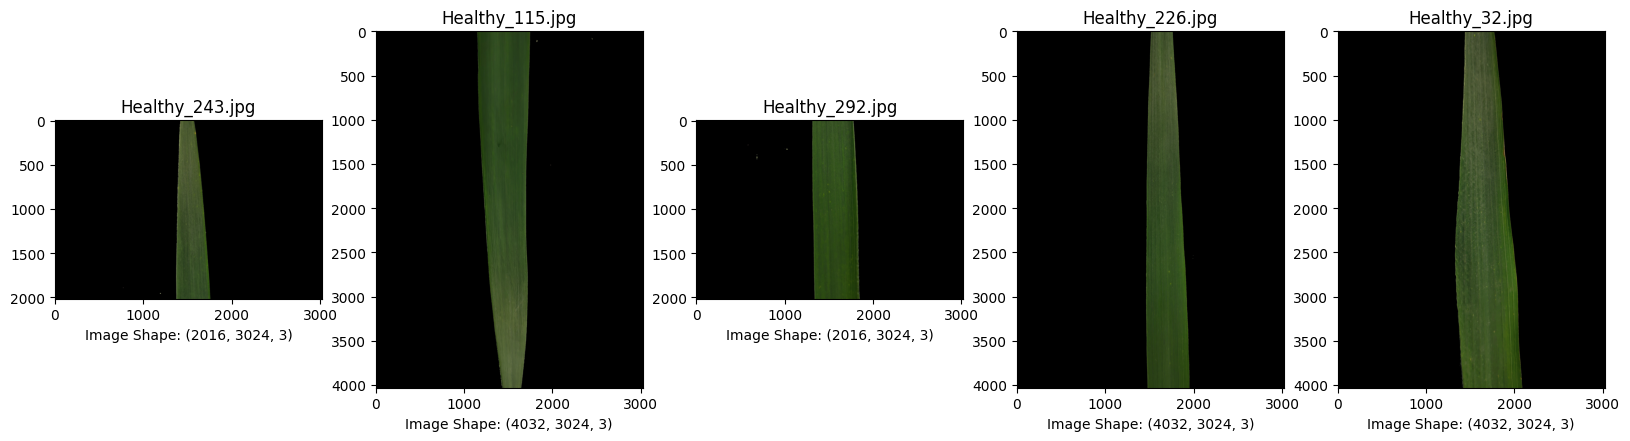

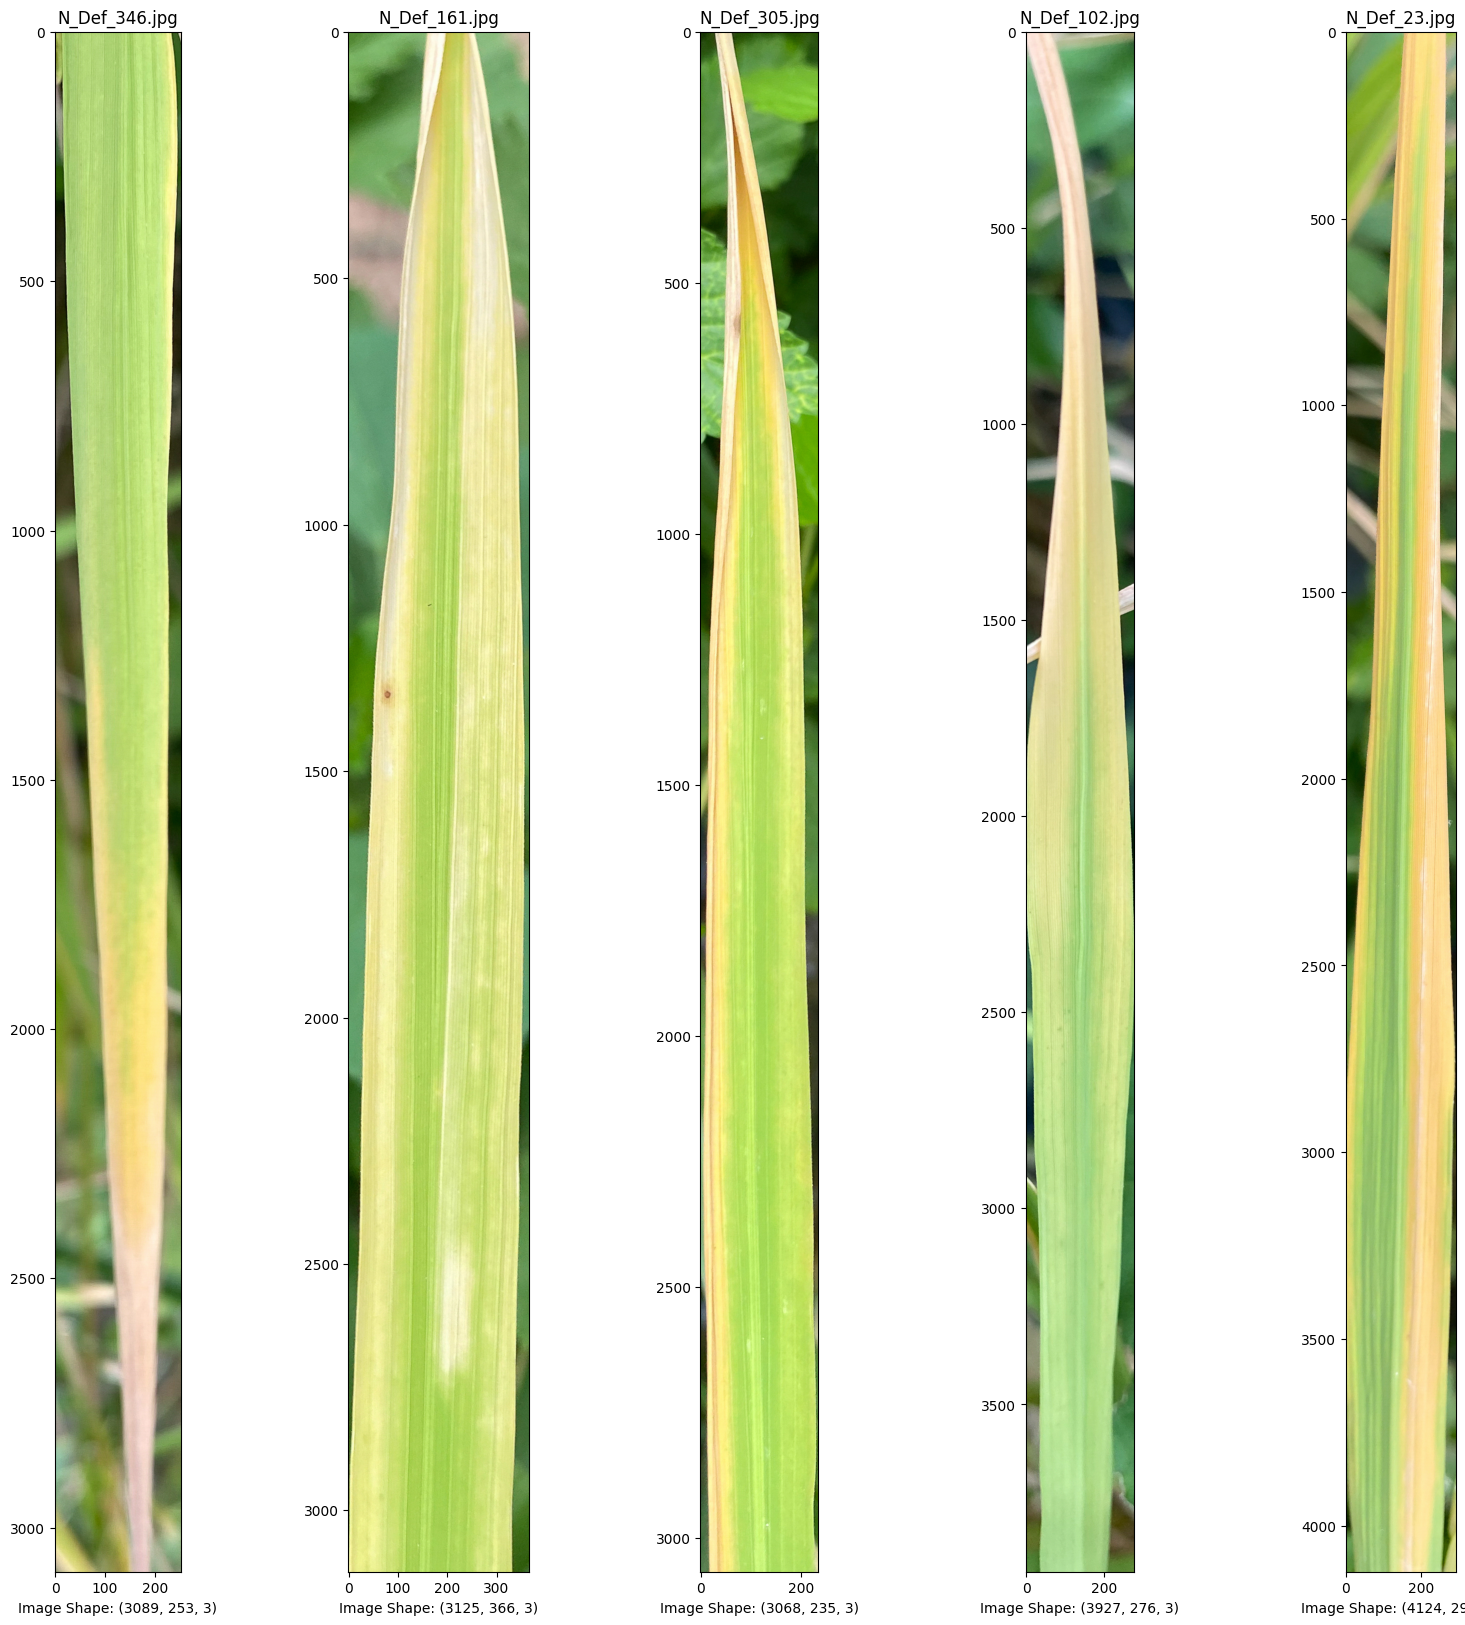

In [4]:
load_random_imgs_from_folder(healthy_dir)
print('\n\n')
load_random_imgs_from_folder(n_def_dir)

## Create a dataframe


In [5]:
labels = []
for label_dir in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, label_dir)):
        labels.append(label_dir)

print(labels)


['Healthy', 'K_Deficiency', 'N_Deficiency', 'P_Deficiency']


In [6]:
IMG_SIZE = 256

In [7]:
# img_size = 256
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                if img[-3:] != 'txt':
                    img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

  

In [8]:
dataset = get_data(dataset_dir)
np.random.shuffle(dataset)

## Splitting the dataset

In [9]:
len(dataset)

1530

In [10]:
train = dataset[:1070]
val = dataset[1070:1300]
test = dataset[1300:]

In [11]:
train_df = pd.DataFrame(train,columns=['Feature','Label'])

In [12]:
l=[]
for i in train_df['Label']:
  l.append(labels[i])

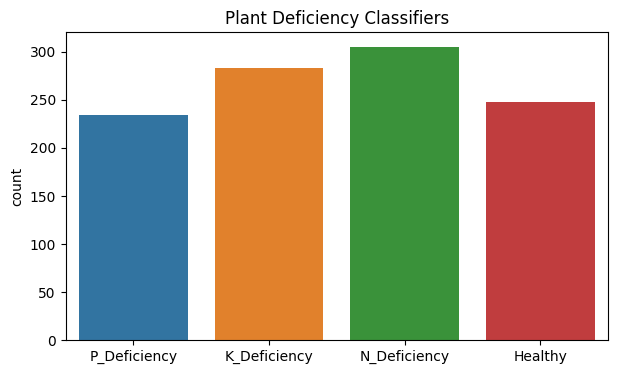

In [13]:
plt.figure(figsize=(7,4))
sns.countplot(x=l);
plt.title('Plant Deficiency Classifiers');

In [14]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Image Preprocessing

## Normalizing the dataset

In [15]:
np.array(x_train).max()

255

In [16]:
np.array(x_train)

array([[[[ 73,  69,  70],
         [ 72,  68,  69],
         [ 70,  66,  67],
         ...,
         [129, 178, 130],
         [126, 177, 128],
         [124, 175, 127]],

        [[ 64,  58,  60],
         [ 65,  59,  61],
         [ 66,  60,  63],
         ...,
         [130, 181, 132],
         [130, 180, 131],
         [129, 180, 131]],

        [[ 70,  66,  67],
         [ 69,  66,  67],
         [ 71,  67,  68],
         ...,
         [131, 183, 135],
         [131, 181, 134],
         [134, 183, 136]],

        ...,

        [[ 48,  43,  34],
         [ 51,  45,  37],
         [ 56,  52,  41],
         ...,
         [144, 139, 118],
         [143, 135, 118],
         [141, 133, 118]],

        [[ 49,  44,  35],
         [ 49,  43,  34],
         [ 55,  50,  38],
         ...,
         [174, 164, 143],
         [175, 164, 143],
         [175, 162, 143]],

        [[ 54,  49,  37],
         [ 53,  49,  40],
         [ 51,  46,  35],
         ...,
         [182, 175, 154],
        

Text(0.5, 1.0, 'K_Deficiency')

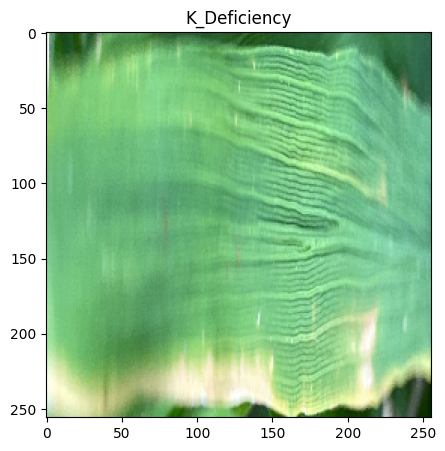

In [17]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)


In [19]:
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)

In [20]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1070, 256, 256, 3),
 (1070,),
 (230, 256, 256, 3),
 (230,),
 (230, 256, 256, 3),
 (230,))

In [21]:
type(y_train[0])

numpy.int32

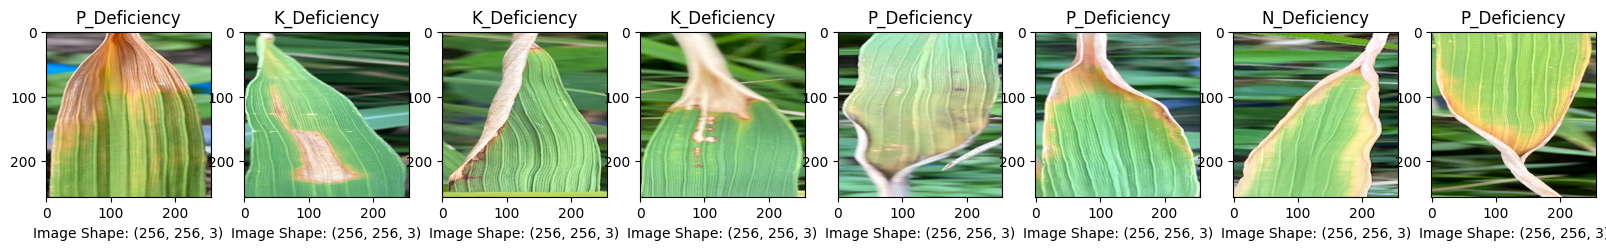

In [22]:
plt.figure(figsize=(20,20))

for i in range(8):
  img = x_train[i]
  ax=plt.subplot(1,8,i+1)
  ax.title.set_text(labels[y_train[i]])
  plt.xlabel(f'Image Shape: {img.shape}')
  plt.imshow(img)


## Image Preprocessing

In [23]:
def plot_before_after(img, filtered_img):
  plt.figure(figsize=(10,10))
  plt.subplot(121),plt.imshow(img),plt.title('Original')
  plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(filtered_img),plt.title('Filtered')
  plt.xticks([]), plt.yticks([])
  plt.show()


In [24]:
class Filters:
  def __init__(self, x_train):
    self.x_train = x_train
  
  def Gaussian_Blurr(self, kernel):
    self.kernel = kernel
    gauss_blurr = []
    for i in range(len(self.x_train)-1):
      f_img = cv2.GaussianBlur(self.x_train[i], self.kernel,0)
      gauss_blurr.append(f_img)
    return gauss_blurr

  def Median_Blurr(self, K):
    self.K = K
    median_blurr = []
    for i in range(len(self.x_train)-1):
      img = self.x_train[i].astype('float32') / 255.0
      f_img = cv2.medianBlur(img, self.K)
      median_blurr.append(f_img)
    return median_blurr

  def Bilateral_Blurr(self, diameter, sigmaColor, sigmaSpace):
    self.d = diameter
    self.sc = sigmaColor
    self.ss = sigmaSpace
    bilateral_blurr = []
    for i in range(len(self.x_train)-1):
      img = self.x_train[i].astype('float32') / 255.0
      f_img = cv2.bilateralFilter(img, self.d, self.sc, self.ss)
      bilateral_blurr.append(f_img)
    return bilateral_blurr

In [25]:
img_filter = Filters(x_train)

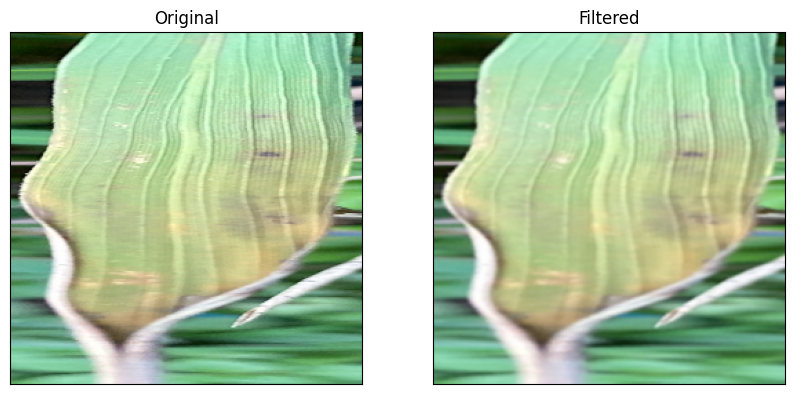

In [26]:
gauss_imgs = img_filter.Gaussian_Blurr((3,3))
plot_before_after(x_train[4], gauss_imgs[4])

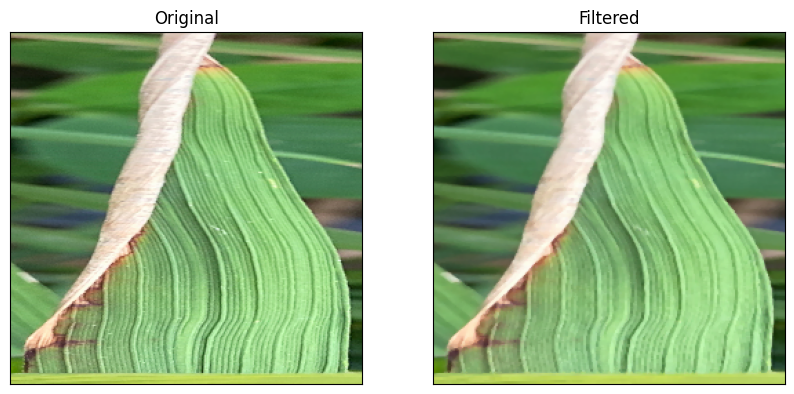

In [27]:
medians = img_filter.Median_Blurr(3)
plot_before_after(x_train[2], medians[2])

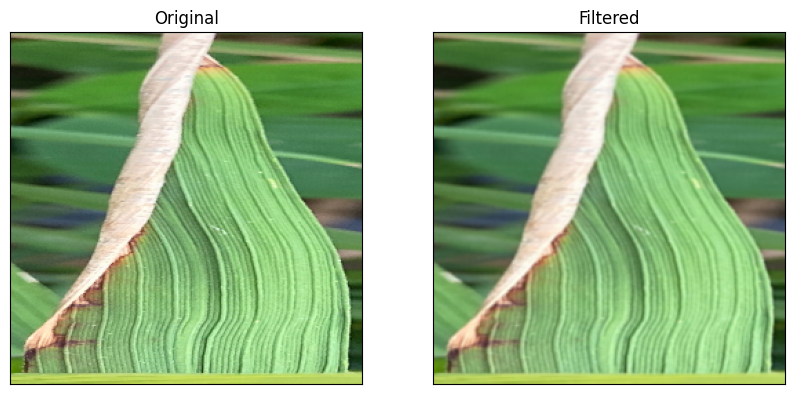

In [28]:
bilateral_imgs = img_filter.Bilateral_Blurr(3, 11, 5)
plot_before_after(x_train[2], bilateral_imgs[2])

## Image Augmentation

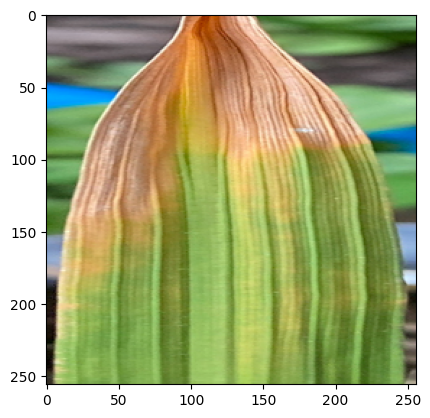

In [29]:
plt.imshow(x_train[0])

In [30]:
x_train[0].shape

(256, 256, 3)

In [31]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    featurewise_center=False,  # set input mean to 0 over the dataset 
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [33]:
# prepare an iterators to scale images
train_iterator_1 = train_datagen.flow(x_train, y_train, batch_size=32)
val_iterator_1 = val_datagen.flow(x_val, y_val, batch_size=32)
print('Batches train=%d, Batches test=%d' % (len(train_iterator_1), len(val_iterator_1)))


Batches train=34, Batches test=8


In [34]:

# confirm the scaling works
batchX, batchy = train_iterator_1.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Batch shape=(32, 256, 256, 3), min=0.000, max=1.000


# Functions

In [35]:
def learning_curve(model_fit, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [36]:
def confusion_matrix_plot(matrix, model):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);
#     plt.savefig(f'CM_{model}.png', dpi=300)
    plt.show()


In [37]:
def cal_score(model, key):
    
        # evaluate the model
    _, train_acc = model.evaluate(x_train/255.0, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, val_acc = model.evaluate(x_val/255.0, y_val, verbose=0)


    print('Train: %.3f, Test: %.3f, Val: %.3f' % (train_acc, test_acc, val_acc))

    # predict probabilities for test set
    yprobs = model.predict(x_test, verbose=0)
    # predict crisp classes for test set
    yclasses = np.argmax(yprobs,axis=1)


    test_kappa = cohen_kappa_score(y_test, yclasses)
    print('Test Cohens kappa: %f' % test_kappa)
#     val_kappa = cohen_kappa_score(y_val, yclasses)
#     print('Val Cohens kappa: %f' % val_kappa)
    print('\n')
    # confusion matrix
    matrix = confusion_matrix(y_test, yclasses)
    print(matrix)
    print('\n')

    f1 = f1_score(y_test, yclasses, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(y_test, yclasses, target_names=labels))
    
    if key==1:
        confusion_matrix_plot(matrix, model)

# Modelling

### MODEL 1

In [38]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8, verbose=0),
             ModelCheckpoint(filepath='weights/xcep_best1.h5', save_best_only=True)]

In [39]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [40]:
from tensorflow.keras.applications.xception import Xception

In [41]:
base_model = Xception(input_shape = (IMG_SIZE, IMG_SIZE, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

In [42]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = Dense(4, activation='softmax')(x)           

xcep_model1 = Model(base_model.input, x) 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.01)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

xcep_model1.compile(optimizer = optimizer, 
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics = ['accuracy'])

In [43]:
xcep_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 127, 127, 32)         0         ['block1_conv1_bn[0][0]'] 

In [44]:
xcep_hist = xcep_model1.fit(train_iterator_1,epochs=100,verbose=1,validation_data=val_iterator_1, callbacks = callbacks)


Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 1.1804 - accuracy: 0.4682

C:\Users\navin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 297s 9s/step - loss: 1.1804 - accuracy: 0.4682 - val_loss: 0.9771 - val_accuracy: 0.6609
Epoch 2/100
34/34 [==============================] - 298s 9s/step - loss: 0.8912 - accuracy: 0.6187 - val_loss: 0.7441 - val_accuracy: 0.7696
Epoch 3/100
34/34 [==============================] - 287s 8s/step - loss: 0.7651 - accuracy: 0.6813 - val_loss: 0.6135 - val_accuracy: 0.7957
Epoch 4/100
34/34 [==============================] - 294s 9s/step - loss: 0.6767 - accuracy: 0.7271 - val_loss: 0.4837 - val_accuracy: 0.8609
Epoch 5/100
34/34 [==============================] - 286s 8s/step - loss: 0.5929 - accuracy: 0.7748 - val_loss: 0.4234 - val_accuracy: 0.8522
Epoch 6/100
34/34 [==============================] - 286s 8s/step - loss: 0.5075 - accuracy: 0.8047 - val_loss: 0.3688 - val_accuracy: 0.8870
Epoch 7/100
34/34 [==============================] - 292s 9s/step - loss: 0.4939 - accuracy: 0.8084 - val_loss: 0.3224 - val_accuracy: 0.9130
Epoch 8/100
34/34 

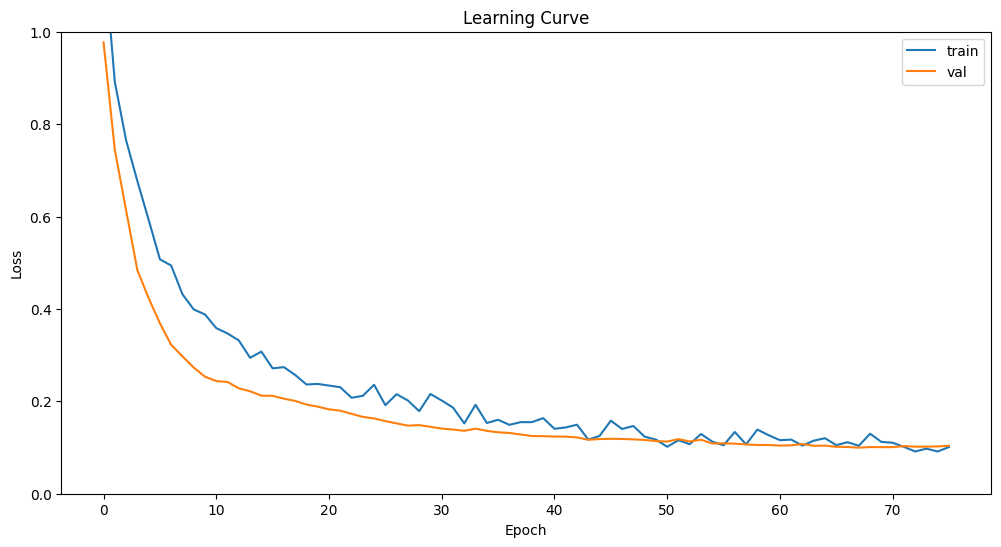

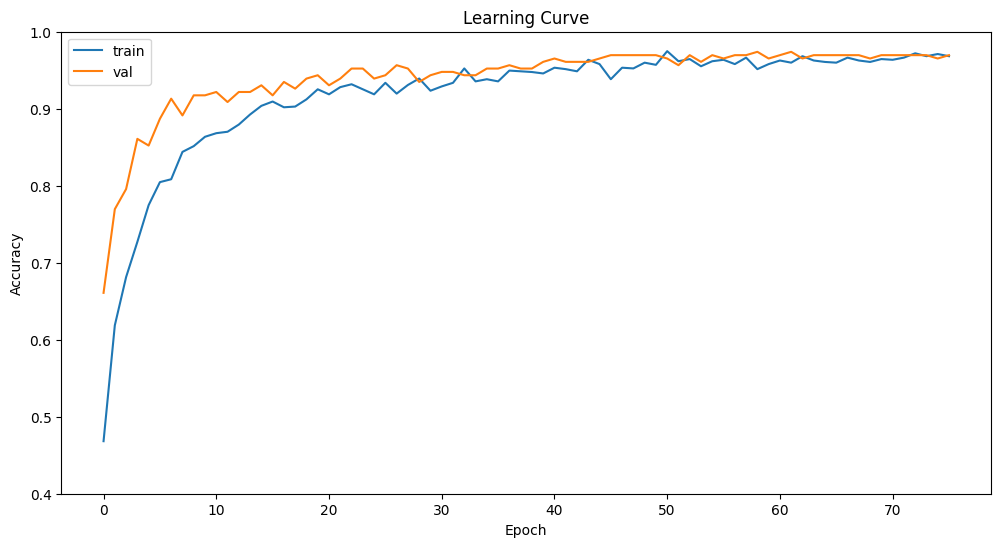

In [45]:
learning_curve(xcep_hist,'loss', ylim=(0,1))
learning_curve(xcep_hist, 'accuracy', ylim=(0.4,1))

Train: 0.993, Test: 0.974, Val: 0.970
Test Cohens kappa: 0.964921


[[54  0  0  0]
 [ 0 46  1  1]
 [ 0  1 72  0]
 [ 0  3  0 52]]


F1 Score: 0.974018206316343


              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        54
K_Deficiency       0.92      0.96      0.94        48
N_Deficiency       0.99      0.99      0.99        73
P_Deficiency       0.98      0.95      0.96        55

    accuracy                           0.97       230
   macro avg       0.97      0.97      0.97       230
weighted avg       0.97      0.97      0.97       230



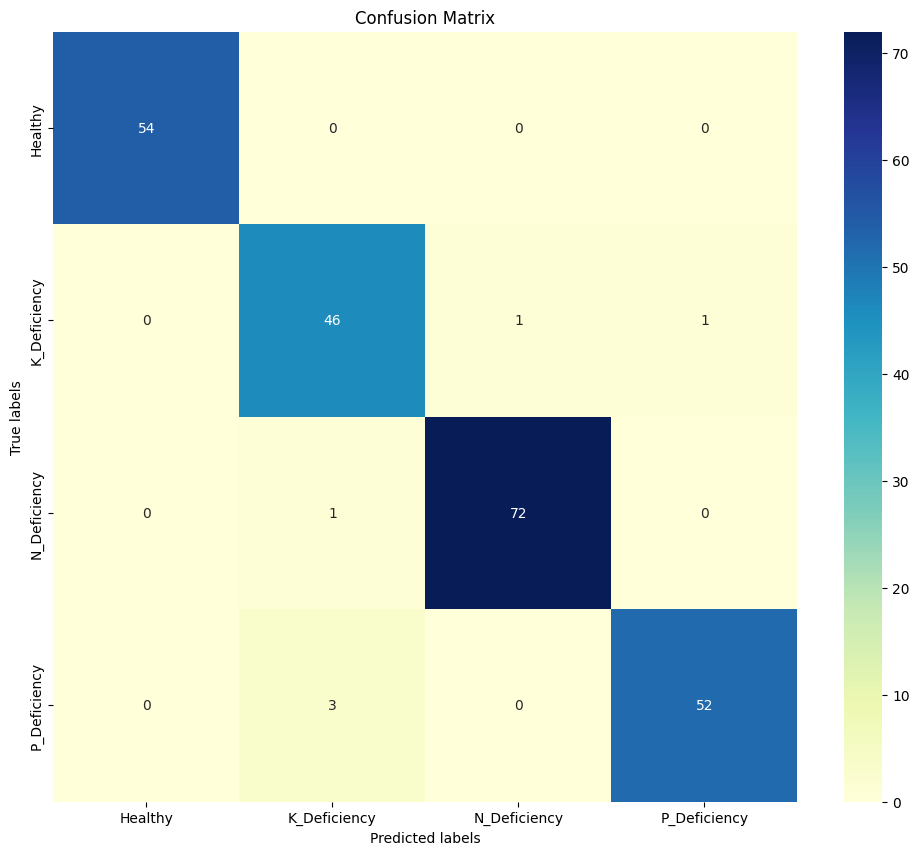

In [46]:
cal_score(xcep_model1, 1) 

In [47]:
from tensorflow.keras.models import load_model

best_model1 = load_model('./weights/xcep_best1.h5')

Train: 0.993, Test: 0.974, Val: 0.970
Test Cohens kappa: 0.964921


[[54  0  0  0]
 [ 0 46  1  1]
 [ 0  1 72  0]
 [ 0  3  0 52]]


F1 Score: 0.974018206316343


              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        54
K_Deficiency       0.92      0.96      0.94        48
N_Deficiency       0.99      0.99      0.99        73
P_Deficiency       0.98      0.95      0.96        55

    accuracy                           0.97       230
   macro avg       0.97      0.97      0.97       230
weighted avg       0.97      0.97      0.97       230



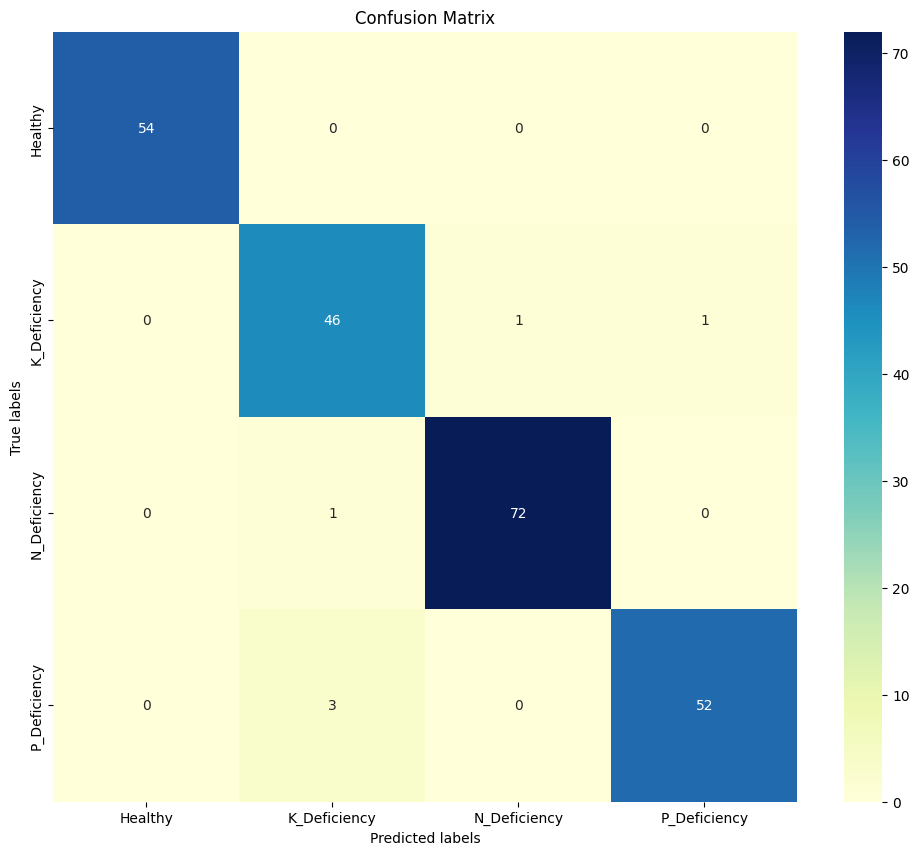

In [48]:
cal_score(best_model1, 1)

In [49]:
# Save the model in the native Keras format
xcep_model1.save('weights.hdf5')

C:\Users\navin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
